# CNN Model Testing

In [1]:
import numpy as np
import os
import utils
from CNNModel import CNN
from torch import optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from bayes_opt import BayesianOptimization

**There are three versions of MNIST dataset**

In [2]:
dataTypes = ["digits-normal.mat", "digits-scaled.mat", "digits-jitter.mat"]

# Accuracy placeholder
accuracy = np.zeros(len(dataTypes))
trainSet = 1
testSet = 2

dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/", "data", "digits-jitter.mat")
data = utils.loadmat(dataPath)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()

# Set random seeds for reproducibility
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)

### Functions Overview

This notebook includes several key functions used for model training, evaluation, reinitialization, and hyperparameter tuning:

- **train(model, dataloader, loss_function, optimizer, epochs, display=True)**  
  Trains the model on the training dataset over a specified number of epochs. It performs forward and backward passes, updates the model parameters, computes the loss and accuracy for each epoch, and optionally prints these metrics. The function returns arrays with the epoch-wise loss and accuracy.

- **evaluate(model, dataloader, loss_function)**  
  Evaluates the model's performance on the test dataset. It computes the average loss and accuracy by running the model in evaluation mode (with gradient calculations disabled) to ensure consistency during inference.

- **reset_weights(m)**  
  A utility function that reinitializes the weights of a model layer if it supports weight resetting (i.e., has a `reset_parameters` method).

- **objective(learning_rate, batch_size, num_epochs)**  
  Defines the objective function for Bayesian optimization. It takes hyperparameters as inputs (learning rate, batch size, and number of epochs), casts those that need to be integers, trains the model using these hyperparameters, and evaluates its test accuracy. The test accuracy is returned as the metric to be maximized during the optimization process.


In [3]:
def train(model, dataloader, loss_function, optimizer, epochs, display=True):
    model.train()
    loss_arr = np.zeros(epochs)
    acc_arr = np.zeros(epochs)
    
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0
        
        for images, labels in dataloader:
            # Move the batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
        
        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        loss_arr[epoch] = total_epoch_loss
        acc_arr[epoch] = epoch_accuracy
        
        if display:
            print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")
    
    return loss_arr, acc_arr

def evaluate(model, dataloader, loss_function):
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0
    with torch.no_grad():
        for images, labels in dataloader:
            # Move the batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    return test_loss, test_acc

def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def objective(learning_rate, batch_size, num_epochs, xTrain, yTrain, xTest, yTest):
    # Convert hyperparameters to appropriate types
    batch_size = int(batch_size)
    num_epochs = int(num_epochs)
    
    # Define model, loss function, and optimizer
    model = CNN()  # Assuming CNN is defined elsewhere and imported
    model.to(device)  # Move model to GPU
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create DataLoaders with drop_last=True to avoid batches with a single sample
    train_dataset = TensorDataset(xTrain, yTrain)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    test_dataset = TensorDataset(xTest, yTest)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # Reset model weights before training
    model.apply(reset_weights)
    
    # Train the model (display is False for hyperparameter tuning)
    train(model, train_loader, loss_function, optimizer, num_epochs, display=False)
    
    # Evaluate on the test set and return test accuracy
    _, test_acc = evaluate(model, test_loader, loss_function)
    return test_acc

In [4]:
# Model Check
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

**Hyperparameter Tuning**

In [5]:
# Dictionary to store the best hyperparameters for each dataset
best_hyperparams = {}

dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/")

# Loop over each dataset in dataTypes
for dataType in dataTypes:
    print("+++ Loading dataset: {} ...".format(dataType))
    path = os.path.join(dataPath, "data", dataType)
    data = utils.loadmat(path)
    print("+++ Loading dataset: {} ({} images)".format(dataType, data["x"].shape[2]))
    
    # Preprocess the data
    x = data["x"].transpose([2, 0, 1])
    x = np.reshape(x, [x.shape[0], 1, x.shape[1], x.shape[2]])
    y = data["y"]

    x = torch.tensor(x).float()
    y = torch.tensor(y).long()

    # Split data into training and testing sets
    xTrain = x[data["set"] == trainSet, :, :, :]
    yTrain = y[data["set"] == trainSet]
    xTest = x[data["set"] == testSet, :, :, :]
    yTest = y[data["set"] == testSet]
    
    # Define the bounds for hyperparameters
    pbounds = {
        'learning_rate': (1e-5, 1e-2),
        'batch_size': (32, 128),
        'num_epochs': (50, 100)
    }
    
    # Set up Bayesian Optimization.
    # The lambda ensures that the extra parameters (xTrain, yTrain, etc.) are passed to the objective.
    optimizer_bo = BayesianOptimization(
        f=lambda learning_rate, batch_size, num_epochs: objective(learning_rate, batch_size, num_epochs, xTrain, yTrain, xTest, yTest),
        pbounds=pbounds,
        random_state=42,
    )
    
    # Run the optimization process
    optimizer_bo.maximize(
        init_points=5,
        n_iter=25
    )
    
    # Store the best hyperparameters for this dataset in the dictionary
    best_hyperparams[dataType] = optimizer_bo.max
    print("Best parameters for {}:".format(dataType))
    print(optimizer_bo.max)
    
print("All best hyperparameters:")
print(best_hyperparams)

+++ Loading dataset: digits-normal.mat ...
+++ Loading dataset: digits-normal.mat (2000 images)
|   iter    |  target   | batch_... | learni... | num_ep... |
-------------------------------------------------------------
| 1         | 0.9339    | 67.96     | 0.009508  | 86.6      |
| 2         | 0.9461    | 89.47     | 0.001569  | 57.8      |
| 3         | 0.9543    | 37.58     | 0.008663  | 80.06     |
| 4         | 0.9576    | 99.97     | 0.0002156 | 98.5      |
| 5         | 0.955     | 111.9     | 0.002131  | 59.09     |
| 6         | 0.9579    | 101.3     | 0.002349  | 98.75     |
| 7         | 0.9283    | 123.0     | 0.006521  | 83.79     |
| 8         | 0.873     | 124.4     | 0.006116  | 50.03     |
| 9         | 0.9442    | 103.1     | 0.004717  | 65.7      |
| 10        | 0.9406    | 101.5     | 0.0056    | 87.16     |
| 11        | 0.9396    | 32.25     | 0.009494  | 68.46     |
| 12        | 0.9677    | 33.73     | 0.009165  | 91.71     |
| 13        | 0.9514    | 43.92     

+++ Loading dataset: digits-normal.mat (2000 images)
Best hyperparameters for digits-normal.mat:
{'batch_size': 33, 'learning_rate': np.float64(0.009164717474804024), 'num_epochs': 91}
Saved plot to training_plots_digits-normal.mat.png


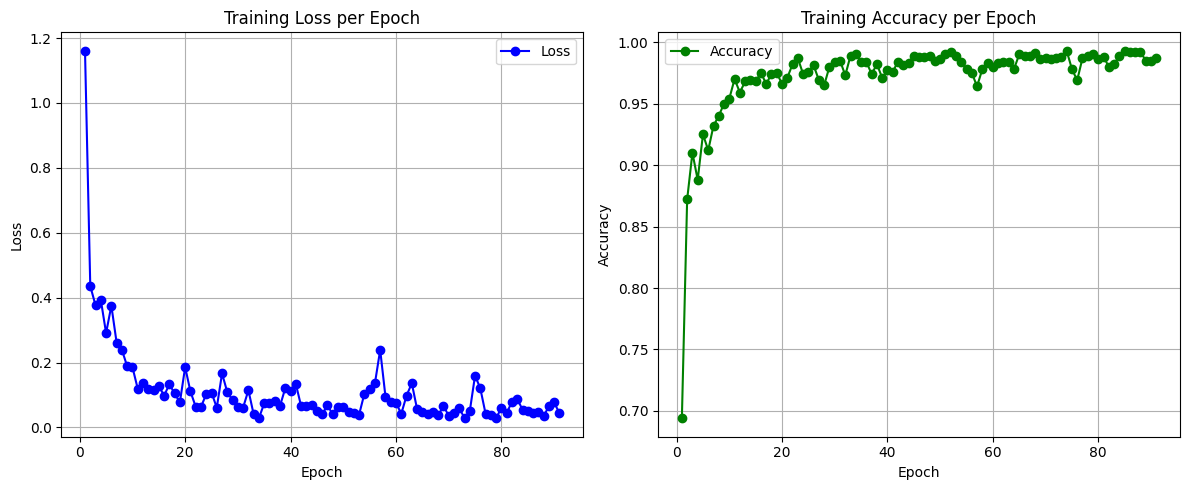

Test accuracy for digits-normal.mat: 0.9620
+++ Loading dataset: digits-scaled.mat (2000 images)
Best hyperparameters for digits-scaled.mat:
{'batch_size': 32, 'learning_rate': np.float64(0.002756762482682119), 'num_epochs': 60}
Saved plot to training_plots_digits-scaled.mat.png


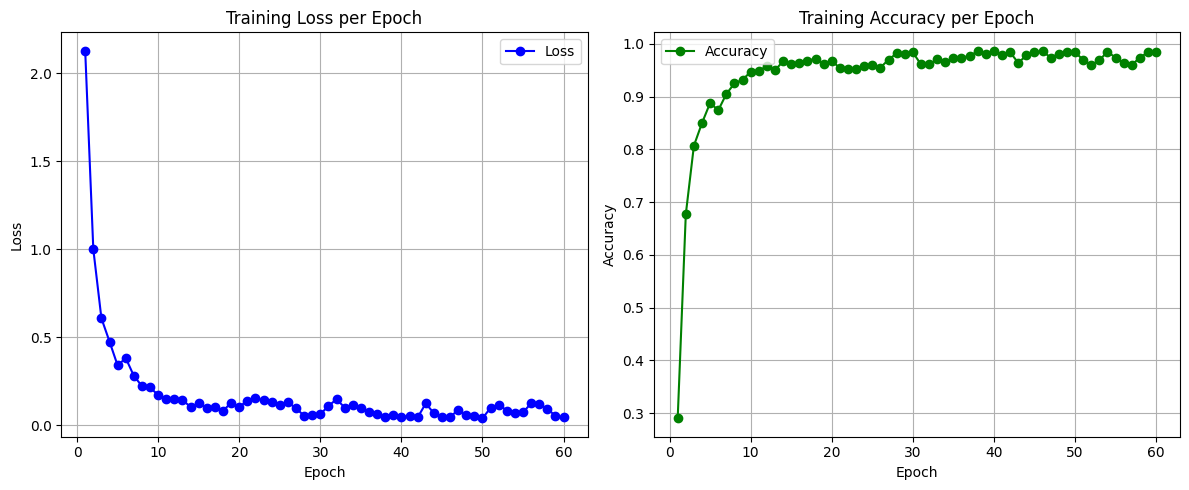

Test accuracy for digits-scaled.mat: 0.9520
+++ Loading dataset: digits-jitter.mat (2000 images)
Best hyperparameters for digits-jitter.mat:
{'batch_size': 116, 'learning_rate': np.float64(0.004225360329435581), 'num_epochs': 62}
Saved plot to training_plots_digits-jitter.mat.png


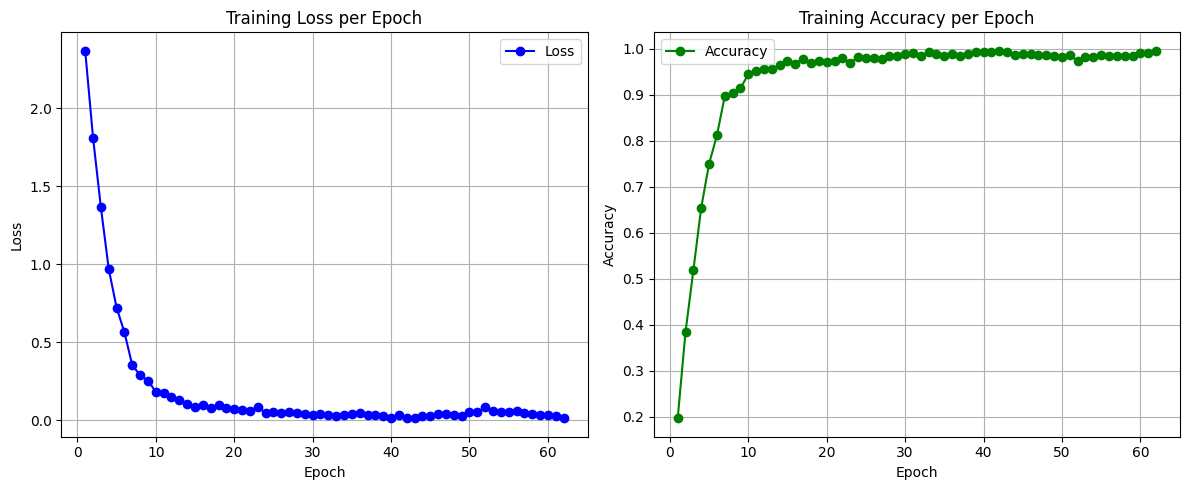

Test accuracy for digits-jitter.mat: 0.7980
Overall Test Accuracies: [0.962 0.952 0.798]


In [8]:
testSet=3
dataPath = os.path.join("/Users/jeddyxie/Desktop/Computer Vision/HW3/Assignment/")
accuracy = np.zeros(len(dataTypes))

for dataset_idx, dataType in enumerate(dataTypes):
    # Load data
    path = os.path.join(dataPath, "data", dataType)
    data = utils.loadmat(path)
    print("+++ Loading dataset: {} ({} images)".format(dataType, data["x"].shape[2]))
    
    x = data["x"].transpose([2, 0, 1])
    x = np.reshape(x, [x.shape[0], 1, x.shape[1], x.shape[2]])
    y = data["y"]
    
    x = torch.tensor(x).float()
    y = torch.tensor(y).long()
    
    xTrain = x[data["set"] == trainSet, :, :, :]
    yTrain = y[data["set"] == trainSet]
    xTest = x[data["set"] == testSet, :, :, :]
    yTest = y[data["set"] == testSet]
    
    # Retrieve hyperparameters for the current dataset from best_hyperparams dict.
    # If not found, use fallback defaults.
    if dataType in best_hyperparams:
        print("Best hyperparameters for {}:".format(dataType))
        best_params = best_hyperparams[dataType]["params"]
        hyperparams = {
            "batch_size": int(best_params["batch_size"]),
            "learning_rate": best_params["learning_rate"],
            "num_epochs": int(best_params["num_epochs"])
        }
        print(hyperparams)
    else:
        hyperparams = {
            "batch_size": 64,
            "learning_rate": 0.001,
            "num_epochs": 150
        }
    
    # Define model, loss function, and optimizer using the hyperparameters.
    model = CNN()
    model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
    
    # Create train dataset and loader.
    train_dataset = TensorDataset(xTrain, yTrain)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=True
    )
    
    # Create test dataset and loader.
    test_dataset = TensorDataset(xTest, yTest)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=True
    )

    # Reset model weights before training.
    model.apply(reset_weights)
    
    EPOCHS = hyperparams["num_epochs"]
    loss, acc = train(model, train_loader, loss_function, optimizer, EPOCHS, display=False)
    
    # Plot training loss and accuracy.
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), loss, marker='o', linestyle='-', color='blue', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), acc, marker='o', linestyle='-', color='green', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    # Save the plot to a file named according to the dataset.
    plot_filename = f"training_plots_{dataType}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {plot_filename}")
    
    plt.show()
    
    # Evaluate on test set.
    test_loss, test_acc = evaluate(model, test_loader, loss_function)
    accuracy[dataset_idx] = test_acc
    print('Test accuracy for {}: {:.4f}'.format(dataType, test_acc))

print("Overall Test Accuracies:", accuracy)

In [9]:
# Print the results in a table
print("+++ Accuracy Table [trainSet={}, testSet={}]".format(trainSet, testSet))
print("--------------------------------------------------")
print("dataset\t\t\t", end="")
print("{}\t".format("cnn"), end="")
print()
print("--------------------------------------------------")
for dataset_idx in range(len(dataTypes)):
    print("{}\t".format(dataTypes[dataset_idx]), end="")
    print("{:.2f}\t".format(accuracy[dataset_idx] * 100))
# Print hyperparameters associated with datasets
print("\nHyperparameters for each dataset:")
print("=================================")
for dataset, results in best_hyperparams.items():
    params = results['params']
    print(f"\nDataset: {dataset}")
    print(f"Batch Size: {round(params['batch_size'])}")
    print(f"Learning Rate: {params['learning_rate']:.4f}")
    print(f"Number of Epochs: {round(params['num_epochs'])}")
    print(f"Best Accuracy: {results['target']:.4f}")
    print("-" * 30)

+++ Accuracy Table [trainSet=1, testSet=3]
--------------------------------------------------
dataset			cnn	
--------------------------------------------------
digits-normal.mat	96.20	
digits-scaled.mat	95.20	
digits-jitter.mat	79.80	

Hyperparameters for each dataset:

Dataset: digits-normal.mat
Batch Size: 34
Learning Rate: 0.0092
Number of Epochs: 92
Best Accuracy: 0.9677
------------------------------

Dataset: digits-scaled.mat
Batch Size: 32
Learning Rate: 0.0028
Number of Epochs: 60
Best Accuracy: 0.9417
------------------------------

Dataset: digits-jitter.mat
Batch Size: 116
Learning Rate: 0.0042
Number of Epochs: 62
Best Accuracy: 0.8427
------------------------------
